https://towardsdatascience.com/finding-m%C2%B2-details-on-a-floorplan-using-unsupervised-learning-f8f8891befa9

Populating the interactive namespace from numpy and matplotlib


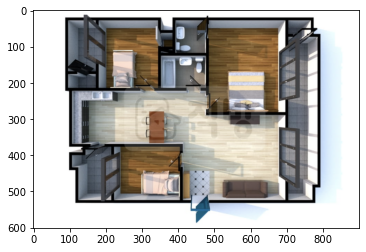

In [2]:

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


img = mpimg.imread('img/zigbang.png')
imgplot = plt.imshow(img)
plt.show()

In [3]:
import os

from skimage.metrics import structural_similarity

import cv2

import argparse
#import imutils

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

cv2.imread("img/zigbang.png")

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

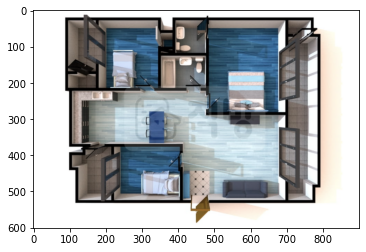

In [4]:
image = cv2.imread('img/zigbang.png', cv2.IMREAD_COLOR)
plt.imshow(image)

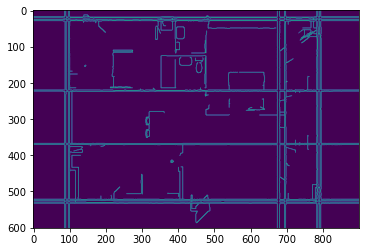

In [14]:
# displaying image
img_canny = cv2.Canny(image, 300, 700, apertureSize = 3)
plt.imshow(img_canny)

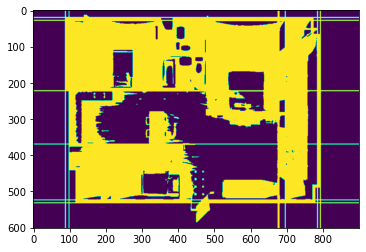

In [16]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (3,3), 0)
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
plt.imshow(gray)
plt.imshow(blur)
plt.imshow(thresh)

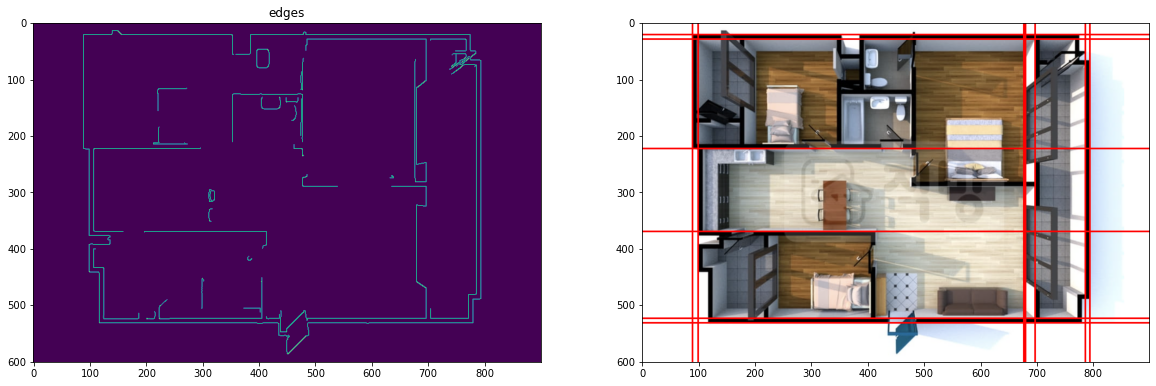

In [15]:
# Load the image
image = cv2.imread('img/zigbang.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20, 20))
# Grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Canny Edges
edges = cv2.Canny(gray, 400, 700, apertureSize = 3)
plt.subplot(2, 2, 1)
plt.title("edges")
plt.imshow(edges)
# Run HoughLines Fucntion 
lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
# Run for loop through each line
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x_1 = int(x0 + 1000 * (-b))
    y_1 = int(y0 + 1000 * (a))
    x_2 = int(x0 - 1000 * (-b))
    y_2 = int(y0 - 1000 * (a))
    cv2.line(image, (x_1, y_1), (x_2, y_2), (255, 0, 0), 2)
# Show Final output
plt.subplot(2, 2, 2)
plt.imshow(image)


In [21]:

def find_rooms(img, noise_removal_threshold=25, corners_threshold=0.1,
               room_closing_max_length=100, gap_in_wall_threshold=500):
    """

    :param img: grey scale image of rooms, already eroded and doors removed etc.
    :param noise_removal_threshold: Minimal area of blobs to be kept.
    :param corners_threshold: Threshold to allow corners. Higher removes more of the house.
    :param room_closing_max_length: Maximum line length to add to close off open doors.
    :param gap_in_wall_threshold: Minimum number of pixels to identify component as room instead of hole in the wall.
    :return: rooms: list of numpy arrays containing boolean masks for each detected room
             colored_house: A colored version of the input image, where each room has a random color.
    """
    assert 0 <= corners_threshold <= 1
    # Remove noise left from door removal

    img[img < 128] = 0
    img[img > 128] = 255
    _, contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img)
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > noise_removal_threshold:
            cv2.fillPoly(mask, [contour], 255)

    img = ~mask

    # Detect corners (you can play with the parameters here)
    dst = cv2.cornerHarris(img ,2,3,0.04)
    dst = cv2.dilate(dst,None)
    corners = dst > corners_threshold * dst.max()

    # Draw lines to close the rooms off by adding a line between corners on the same x or y coordinate
    # This gets some false positives.
    # You could try to disallow drawing through other existing lines for example.
    for y,row in enumerate(corners):
        x_same_y = np.argwhere(row)
        for x1, x2 in zip(x_same_y[:-1], x_same_y[1:]):

            if x2[0] - x1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x1, y), (x2, y), color, 1)

    for x,col in enumerate(corners.T):
        y_same_x = np.argwhere(col)
        for y1, y2 in zip(y_same_x[:-1], y_same_x[1:]):
            if y2[0] - y1[0] < room_closing_max_length:
                color = 0
                cv2.line(img, (x, y1), (x, y2), color, 1)


    # Mark the outside of the house as black
    _, contours, _ = cv2.findContours(~img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]
    mask = np.zeros_like(mask)
    cv2.fillPoly(mask, [biggest_contour], 255)
    img[mask == 0] = 0

    # Find the connected components in the house
    ret, labels = cv2.connectedComponents(img)
    img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    unique = np.unique(labels)
    rooms = []
    for label in unique:
        component = labels == label
        if img[component].sum() == 0 or np.count_nonzero(component) < gap_in_wall_threshold:
            color = 0
        else:
            rooms.append(component)
            color = np.random.randint(0, 255, size=3)
        img[component] = color

    return rooms, img



#Read gray image
img = cv2.imread("img/zigbang.png", 0)
rooms, colored_house = find_rooms(img.copy())


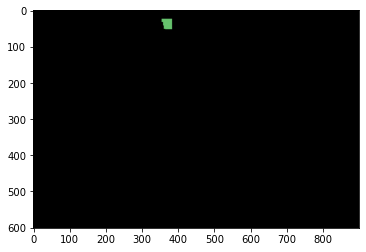

In [22]:
plt.imshow( colored_house)

import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\USER\AppData\Local\Tesseract-OCR\tesseract.exe'

print(pytesseract.image_to_string(thresh))